In [65]:
import os
import numpy as np
import pandas as pd
import os
import torch
import warnings
from mvquant.dataloader.dataloader import DatasetCustom
from mvquant.models import DLinear, NLinear, PatchTST
from mvquant.models.stat_models import Arima
from torch.utils.data import DataLoader
import json
from mvquant.dataloader.api import *
from pandas.tseries.offsets import BusinessDay
import plotly.graph_objects as go
warnings.filterwarnings('ignore')

In [66]:
symbol = "UPINDEX"
data_path = f"../datasets/{symbol}.parquet"

In [67]:
from types import SimpleNamespace

configs = SimpleNamespace(
    task_name="short_term_forecast",
    batch_size=512,
    is_training=1,
    seq_len=96, # 96  36 48 60 72 144 288
    pred_len=96, # 96 192 336
    label_len=0, # 48, 18
    seasonal_patterns=None, # not used in this dataset
    moving_avg=25, # 25 default
    embed="timeF",
    activation="gelu",
    output_attention=False,
    learning_rate=0.001,
    epoch=30,
    freq="D",
    enc_in=1, # number of features, 1 in case forecasting
    num_class=1, # in case classification
    individual=True,
    scale=True,
    time_enc=1,
    features="S", # ["S", "M", "MS"]
    # transformer model
    d_model=16,
    e_layers=3,
    d_ff=128,
    c_out=1,
    factor=3,
    n_heads=4,
    dropout=0.1, # 0.3 for patchTST
    # fc_dropout=0.3, # dont use
    head_dropout=0,
    patch_len = 16,
    stride = 8
)

time_configs = SimpleNamespace(
    task_name="short_term_forecast",
    batch_size=256,
    is_training=1,
    seq_len=24, # 96  36 48 60 72 144 288
    pred_len=24, # 96 192 336
    label_len=0, # 48, 18
    epoch=100,
    freq="D",
    enc_in=1, # number of features, 1 in case forecasting
    num_class=1, # in case classification
    individual=True,
    scale=True,
    time_enc=1,
    features="S", # ["S", "M", "MS"]
    sample=1,
)

In [68]:
train_test_ratio = (0.95, 0.05)
train_dataset = DatasetCustom(
    flag="train",
    features=configs.features, 
    data_path=data_path, 
    target="last_closeRaw", 
    timeenc=configs.time_enc, 
    freq=configs.freq,
    scale=configs.scale,
    size=(configs.seq_len, configs.label_len, configs.pred_len),
    train_test_ratio = train_test_ratio,
    # train_only=True
)
val_dataset = DatasetCustom(
    flag="val",
    features=configs.features, 
    data_path=data_path, 
    target="last_closeRaw", 
    timeenc=configs.time_enc, 
    freq=configs.freq,
    scale=configs.scale,
    size=(configs.seq_len, configs.label_len, configs.pred_len),
    train_test_ratio = train_test_ratio
)
test_dataset = DatasetCustom(
    flag="test",
    features=configs.features, 
    data_path=data_path, 
    target="last_closeRaw", 
    timeenc=configs.time_enc, 
    freq=configs.freq,
    scale=configs.scale,
    size=(configs.seq_len, configs.label_len, configs.pred_len),
    train_test_ratio = train_test_ratio
)

train_dataloader= DataLoader(train_dataset, batch_size=configs.batch_size, drop_last=True, shuffle=True)
val_dataloader= DataLoader(val_dataset, batch_size=configs.batch_size, drop_last=False, shuffle=False)
test_dataloader= DataLoader(test_dataset, batch_size=configs.batch_size, drop_last=False, shuffle=False)

In [69]:
def get_model(name, configs):
    models = dict(
        dlinear = DLinear(configs),
        nlinear = NLinear(configs),
        patchtst = PatchTST(configs),
        arima = Arima(time_configs)
    )
    return models[name]
model = get_model("dlinear", configs)
optimizer = torch.optim.Adam(model.parameters(), lr=configs.learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, gamma=0.5)
best_state = {}
best_val_loss = float("inf")
best_epoch = -1
f_dim = 0 if configs.features=="S" else -1

In [70]:
from copy import deepcopy
for epoch in range(configs.epoch):
    model.train()
    train_losses = []
    for batch in train_dataloader:
        seq_x, seq_y, seq_x_mark, seq_y_mark = batch
        optimizer.zero_grad(set_to_none=True)
        seq_x = seq_x.to(torch.float32)
        seq_y = seq_y.to(torch.float32)
        pred = model(seq_x, seq_x_mark, seq_y, seq_y_mark)[:, -configs.pred_len:, f_dim:]
        seq_y = seq_y[:, -configs.pred_len:, f_dim:]
        loss = torch.nn.functional.mse_loss(pred, seq_y)
        train_losses.append(loss.detach().item())
        loss.backward()
        optimizer.step()
    scheduler.step()
    print(f"{epoch=} {np.mean(train_losses)=:.5f}")
    if len(test_dataset) > 0:
        with torch.no_grad():
            model.eval()
            val_loss = []
            test_forecast = []
            for batch in test_dataloader:
                seq_x, seq_y, seq_x_mark, seq_y_mark = batch
                seq_x = seq_x.to(torch.float32)
                seq_y = seq_y.to(torch.float32)
                pred = model(seq_x, seq_x_mark, seq_y, seq_y_mark)[:, -configs.pred_len:, f_dim:]
                seq_y = seq_y[:, -configs.pred_len:, f_dim:]
                loss = torch.nn.functional.mse_loss(pred, seq_y).item()
                val_loss.append(loss)
                test_forecast.append(pred[0,:,:])
            val_loss = np.mean(val_loss)
            if val_loss < best_val_loss:
                best_epoch = epoch
                best_val_loss = val_loss
                best_state = deepcopy(model.state_dict())
            train_loss = np.mean(train_losses)
            print(f"{epoch=} {train_loss=:.5f} {val_loss=:.5f} {best_val_loss=:.5f} {best_epoch=}"  , sep="\n")


epoch=0 np.mean(train_losses)=0.91085
epoch=0 train_loss=0.91085 val_loss=1.09654 best_val_loss=1.09654 best_epoch=0
epoch=1 np.mean(train_losses)=0.48797
epoch=1 train_loss=0.48797 val_loss=0.40810 best_val_loss=0.40810 best_epoch=1
epoch=2 np.mean(train_losses)=0.36876
epoch=2 train_loss=0.36876 val_loss=0.19233 best_val_loss=0.19233 best_epoch=2
epoch=3 np.mean(train_losses)=0.32851
epoch=3 train_loss=0.32851 val_loss=0.13706 best_val_loss=0.13706 best_epoch=3
epoch=4 np.mean(train_losses)=0.30050
epoch=4 train_loss=0.30050 val_loss=0.12775 best_val_loss=0.12775 best_epoch=4
epoch=5 np.mean(train_losses)=0.29220
epoch=5 train_loss=0.29220 val_loss=0.13430 best_val_loss=0.12775 best_epoch=4
epoch=6 np.mean(train_losses)=0.27153
epoch=6 train_loss=0.27153 val_loss=0.13486 best_val_loss=0.12775 best_epoch=4
epoch=7 np.mean(train_losses)=0.26243
epoch=7 train_loss=0.26243 val_loss=0.12582 best_val_loss=0.12582 best_epoch=7
epoch=8 np.mean(train_losses)=0.25497
epoch=8 train_loss=0.25497

In [71]:
test_forecast = []
if len(test_dataset) > 0:
    with torch.no_grad():
        model.eval()
        val_loss = []
        test_forecast = []
        for batch in test_dataloader:
            seq_x, seq_y, seq_x_mark, seq_y_mark = batch
            seq_x = seq_x.to(torch.float32)
            seq_y = seq_y.to(torch.float32)
            pred = model(seq_x, seq_x_mark, seq_y, seq_y_mark)[:, -configs.pred_len:, f_dim:]
            seq_y = seq_y[:, -configs.pred_len:, f_dim:]
            loss = torch.nn.functional.mse_loss(pred, seq_y).item()
            val_loss.append(loss)
            test_forecast.append(pred[0,:,:])
        val_loss = np.mean(val_loss)
        if val_loss < best_val_loss:
            best_epoch = epoch
            best_val_loss = val_loss
            best_state = deepcopy(model.state_dict())
        train_loss = np.mean(train_losses)
        print(f"{epoch=} {train_loss=:.5f} {val_loss=:.5f} {best_val_loss=:.5f} {best_epoch=}"  , sep="\n")

epoch=29 train_loss=0.22586 val_loss=0.07544 best_val_loss=0.07544 best_epoch=29


0.17511990456455998

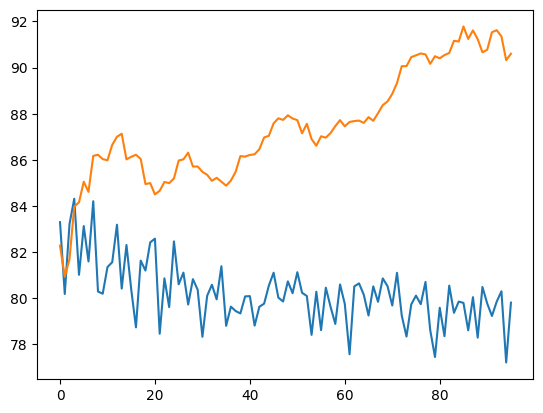

In [72]:
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error


plt.plot(train_dataset.inverse_transform(pred[0].numpy()))
plt.plot(train_dataset.inverse_transform(test_dataset.data_y[-configs.seq_len:][0:configs.pred_len]))
mean_squared_error(pred[0].numpy(), test_dataset.data_y[-configs.seq_len:][0:configs.pred_len])

In [73]:
# checkpoint = torch.load(f"../models/checkpoints/model_{symbol}_dlinear_96_96_full.pth")
# model = DLinear(configs)
# model.load_state_dict(checkpoint['model'])
# model.load_state_dict(best_state)

In [74]:
scaler =  train_dataset.scaler
with torch.no_grad():
    model.eval()
    val_losses = []
    conformal_scores = []
    for batch in test_dataloader:
        seq_x, seq_y, seq_x_mark, seq_y_mark = batch
        seq_x = seq_x.to(torch.float32)
        seq_y = seq_y.to(torch.float32)
        pred = model(seq_x, seq_x_mark, seq_y, seq_y_mark)[:, -configs.pred_len:, f_dim:]
        seq_y = seq_y[:, -configs.pred_len:, f_dim:]
        loss = torch.nn.functional.mse_loss(pred, seq_y)
        val_losses.append(loss.item())
        pred = scaler.inverse_transform(pred.numpy().reshape(1,-1))[0]
        seq_y = scaler.inverse_transform(seq_y.numpy().reshape(1,-1))[0]
        conformal_scores.append(abs(pred - seq_y)/pred)
    print(f"test_mse_loss:{np.mean(val_losses):.5f}", sep="\n")
pi95 = np.quantile(np.concatenate(conformal_scores), q=0.95)
pi80 = np.quantile(np.concatenate(conformal_scores), q=0.8)
print(pi95, np.concatenate(conformal_scores).max(), np.concatenate(conformal_scores).min())

test_mse_loss:0.07544
0.14069238379597662 0.20272397 3.0085848e-06


# Arima

In [75]:
import pmdarima as pm 
from pmdarima.arima import ndiffs
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape
import matplotlib.pyplot as plt

train_arima_dataset = DatasetCustom(
    flag="train",
    features=configs.features, 
    data_path=data_path, 
    target="last_closeRaw", 
    timeenc=configs.time_enc, 
    freq=configs.freq,
    scale=configs.scale,
    size=(configs.seq_len, configs.label_len, configs.pred_len),
    train_test_ratio = train_test_ratio,
    train_only=True
)

In [76]:
# kpss_diffs = ndiffs(train_dataset.data_x, alpha=0.05, test="kpss", max_d=6)
# adf_diffs = ndiffs(train_dataset.data_x, alpha=0.05, test="adf", max_d=6)
# n_diffs = max(adf_diffs, kpss_diffs)

# print(f"Estimated differencing term: {n_diffs}")
# # Estimated differencing term: 1
# arima_model = pm.auto_arima(
#     train_dataset.data_x,
#     d=n_diffs,
#     seasonal=True,
#     stepwise=True,
#     m=10,
#     suppress_warnings=True,
#     error_action="ignore",
#     max_p=6,
#     max_order=None,
#     trace=True,
# )
# print(arima_model.order)

# def forecast_n_step(step=96):
#     fc, conf_int = arima_model.predict(n_periods=step, return_conf_int=True)
#     return (
#         fc,
#         np.asarray(conf_int).tolist())
# arima_val, val_conf_int = forecast_n_step(len(val_dataset.data_x))
# print(mean_squared_error(val_dataset.data_x, arima_val))
# plt.plot(train_dataset.inverse_transform(val_dataset.data_x).reshape(-1))
# plt.plot(train_dataset.inverse_transform(arima_val.reshape(-1,1)).reshape(-1))

# for i, new_ob in enumerate(test_dataset.data_x[-time_configs.pred_len:]):
#     arima_model.update(new_ob)
# scaler.inverse_transform(test_dataset.data_x[-time_configs.pred_len:]).reshape(-1)
# fc, conf = forecast_n_step(time_configs.pred_len)
# arima_forcast = scaler.inverse_transform(fc.reshape(-1,1))
# arima_forcast.reshape(-1)

# Future forecast

In [77]:
from datetime import datetime, timedelta, timezone
from mvquant.dataloader.api import get_historical_price_vnd

In [78]:
data = pd.read_parquet(f"../datasets/{symbol}.parquet")
data.head()

,rowDate,last_closeRaw,last_openRaw,last_maxRaw,last_minRaw,volumeRaw
0,2009-06-29,81.830002,81.830002,81.830002,81.830002,356024.0
1,2009-06-30,77.669998,77.669998,77.669998,77.669998,48309.0
2,2009-07-01,72.519997,72.470001,72.580002,72.470001,89490.0
3,2009-07-02,70.910004,71.110001,74.139999,68.129997,388001.0
4,2009-07-03,74.459999,70.110001,74.459999,70.110001,281482.0


In [79]:
tz = timezone(timedelta(hours=7))
start_time = int((data.rowDate.max() + BusinessDay(-1)).timestamp())
end_time = int(datetime.now(tz=tz).timestamp())
forecast_gt_df = get_historical_price_vnd(symbol=symbol, start_time=start_time, end_time=end_time)
forecast_gt_df.tail()

,rowDate,last_closeRaw,last_openRaw,last_maxRaw,last_minRaw,volumeRaw
0,2024-03-18,90.320457,91.353165,91.448578,89.386635,59068000.0
1,2024-03-19,90.603218,90.323418,90.683548,90.219154,30470200.0


In [80]:
model.eval()
with torch.no_grad():
    pred_seq_x, pred_seq_y, pred_seq_x_mark, pred_seq_y_mark = test_dataset[len(test_dataset.data_x) - configs.seq_len]
    pred_seq_x = torch.as_tensor(pred_seq_x)[None, :].to(torch.float32)
    pred_seq_y = torch.as_tensor(pred_seq_y)[None, :].to(torch.float32)
    pred_new = model(pred_seq_x, pred_seq_x_mark, pred_seq_y, pred_seq_y_mark)[:, -configs.pred_len:, 0:]
    print(pred_seq_x.shape, pred_new.shape)

torch.Size([1, 96, 1]) torch.Size([1, 96, 1])


In [81]:
last_days = np.round(test_dataset.inverse_transform(pred_seq_x.numpy().reshape(1,-1))[0],2)
next_days = np.round(test_dataset.inverse_transform(pred_new.numpy().reshape(1,-1))[0],2)
next_days_pi95_low = np.round(next_days*(1-pi95),2)
next_days_pi95_high = np.round(next_days*(1+pi95),2) 
next_days_pi80_low = np.round(next_days*(1-pi80),2) 
next_days_pi80_high = np.round(next_days*(1+pi80),2) 

In [82]:
pi95, pi80

(0.14069238379597662, 0.07711459845304493)

In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3677 entries, 0 to 3676
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   rowDate        3677 non-null   datetime64[ns]
 1   last_closeRaw  3677 non-null   Float32       
 2   last_openRaw   3677 non-null   Float32       
 3   last_maxRaw    3677 non-null   Float32       
 4   last_minRaw    3677 non-null   Float32       
 5   volumeRaw      3677 non-null   Float32       
dtypes: Float32(5), datetime64[ns](1)
memory usage: 118.6 KB


In [84]:
df_holiday = pd.read_csv("../datasets/vn_holiday_2025.csv")
df_holiday.head()

,Day,Date,Holiday Name,Type,Comments
0,Sunday,2023-01-01,New Year's Day,National Holiday,NaN
1,Monday,2023-01-02,New Year's Day (in lieu),National Holiday,NaN
2,Friday,2023-01-20,Tet Eve Holiday,Government Holiday,Public sector
3,Saturday,2023-01-21,Tet Eve,National Holiday,Vietnamese New Year
4,Sunday,2023-01-22,Tet Nguyen Dan,National Holiday,Vietnamese New Year


In [85]:
last_date = data.rowDate.max() + BusinessDay(1)
pred_dates = pd.bdate_range(last_date, pd.Timestamp(last_date) + BusinessDay(configs.pred_len+ 50)) # add more 50 days due to holiday offline
pred_dates = list(filter(lambda x: x not in df_holiday["Date"].tolist(), pred_dates))
pred_dates = pred_dates[:configs.pred_len]
data_visual = data.query("rowDate >= '2022/01/01'")

colors = {
    "train": "rgb(48, 133, 195)",
    "forecast": "rgb(233, 184, 36)",
    "actual": "rgb(33, 156, 144)",
    "fill95": "rgba(255, 217, 61,0.1)",
    "fill80": "rgba(255, 217, 61,0.15)",
}

template="plotly_dark"
plot_data = []

plot_data.append(
    go.Scatter(
        x=data_visual.rowDate,
        y=data_visual.last_closeRaw,
        name="Training",
        legendrank=1,
        line=dict(color=colors["train"], width=2),
    )
)
plot_data.append(
    go.Scatter(
        x=pred_dates,
        y=next_days,
        name="Forecast",
        line=dict(color=colors["forecast"], width=2),
        legendrank=2
    )
)

plot_data.append(
    go.Scatter(
        x=forecast_gt_df.rowDate,
        y=forecast_gt_df.last_closeRaw,
        name="Actual",
        line=dict(color=colors["actual"], width=2),
        legendrank=3,
        mode="lines",
    )
)

plot_data.append(
    go.Scatter(
        x=pred_dates, 
        y=next_days_pi95_high,
        line=dict(color="rgba(0,0,0,0)"), 
        showlegend=False,
        hoverinfo="skip"
    )
)
plot_data.append(
    go.Scatter(
        x=pred_dates,
        y=next_days_pi95_low,
        name="Predict Interval 95th",
        fill="tonexty",
        fillcolor=colors["fill95"],
        line=dict(color="rgba(0,0,0,0)"),
        hoverinfo="skip",
    )
)
plot_data.append(
    go.Scatter(
        x=pred_dates, y=next_days_pi80_high, line=dict(color="rgba(0,0,0,0)"), showlegend=False, hoverinfo="skip"
    )
)
plot_data.append(
    go.Scatter(
        x=pred_dates,
        y=next_days_pi80_low,
        name="Predict Interval 80th",
        fill="tonexty",
        fillcolor=colors["fill80"],
        line=dict(color="rgba(0,0,0,0)"),
        hoverinfo="skip",
    )
)



layout = dict(
    title=dict(text=f"{symbol} LONGTERM FORECASTING"),
    hovermode="x unified",
    font_size=13,
    legend=dict(
        borderwidth=2,
    ),
    template=template,
    yaxis=dict(
        title=symbol,
        # linecolor="black" if "white" in template else "white",
        showgrid=True,
        gridwidth=1,
    ),
    xaxis=dict(
        # linecolor="black" if "white" in template else "white",
        title="Date",
        rangeslider_visible=True,
        rangeselector=dict(
            buttons=list(
                [
                    dict(count=6, label="6M", step="month", stepmode="backward"),
                    dict(count=1, label="1Y", step="year", stepmode="backward"),
                    dict(count=1, label="YTD", step="year", stepmode="todate"),
                    dict(step="all", label="ALL"),
                ]
            ),
            # font=dict(color="black"),
        ),
    ),
)
fig = go.Figure(data=plot_data, layout=layout)
fig.show()

In [87]:
torch.save(
    {
        "model": model.state_dict(),
        "scaler": train_dataset.scaler
    },
    f"../models/checkpoints/model_{symbol}_dlinear.pth"
)